Graph Attention Networks



## Outline

- colab 에서 실행하기 위한 setting

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 19.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/graph')
!ls

'graph attention networks - cancer data'
 node.csv
 totaledge_edge_breast-cancer.csv
 totaledge_edge_cancer.csv
 totaledge_edge_colorectal-cancer.csv
 totaledge_edge_endometrial-cancer.csv
 totaledge_edge_glioma.csv
 totaledge_edge_renal-cell-carcinoma.csv
 totalnode_brca_tcga.csv
 totalnode_brca_tcga_pan_can_atlas_2018.csv
 totalnode_brca_tcga_pub2015.csv
 totalnode_ccle_broad_2019.csv
 totalnode_coadread_tcga_pan_can_atlas_2018.csv
 totalnode_kirc_tcga.csv
 totalnode_lgg_tcga.csv
 totalnode_ucec_tcga_pan_can_atlas_2018.csv


In [42]:
from typing import Union, Tuple, Optional

from torch_geometric.nn.inits import glorot
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

import torch
from torch import Tensor
import torch.nn.functional as F
from torch_geometric.nn.conv import GATConv
from torch_geometric.utils import (
    add_self_loops,
    softmax,
)


class GATEdgeConv(GATConv):
      def edge_update(self, alpha_j: Tensor, alpha_i: OptTensor,
                    edge_attr: OptTensor, index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:

        alpha = alpha_j if alpha_i is None else alpha_j + alpha_i
        if index.numel() == 0:
            return alpha
        if edge_attr is not None and self.lin_edge is not None:
            if edge_attr.dim() == 1:
                edge_attr = edge_attr.view(-1, 1)
            edge_attr = self.lin_edge(edge_attr)
            edge_attr = edge_attr.view(-1, self.heads, self.out_channels)
            alpha_edge = (edge_attr * self.att_edge).sum(dim=-1)
            alpha = alpha + alpha_edge

        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

In [44]:

import torch.utils.data as data
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import torch_geometric.transforms as T
import pandas as pd
from torch_geometric.data import Batch

node_data = pd.read_csv('node.csv').dropna(axis=0)

node_data = node_data[node_data['cancer_type']=='Breast Cancer']
node_data = node_data[node_data['path']=='breast-cancer']
node_data = node_data.reset_index(drop=True)


node_data_type_detailed = node_data['cancer_type_detailed'].unique()

file_name = f'totaledge_edge_breast-cancer.csv'
edge_data = pd.read_csv(file_name).dropna(axis=0)
edge_data = edge_data.reset_index(drop=True)


x = torch.tensor(node_data.drop(['cancer_type', 'cancer_type_detailed', 'path'], axis=1).values, dtype=torch.float)

index_mapping = {value: index for index, value in enumerate(node_data.drop(['cancer_type', 'cancer_type_detailed', 'path'], axis=1).columns)}

# source 및 target 컬럼에 대해 매핑 적용
edge_data['source'] = edge_data['source'].map(index_mapping)
edge_data['target'] = edge_data['target'].map(index_mapping)


edge_index = torch.tensor(edge_data[['source', 'target']].values.T, dtype=torch.long)
edge_weight = torch.tensor(edge_data['weight'].values, dtype=torch.float)

node_data['cancer_type_detailed'], _ = pd.factorize(node_data['cancer_type_detailed'])

y = torch.tensor(node_data['cancer_type_detailed'].values, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)

print(data.num_nodes, data.num_edges)
data.transform = T.NormalizeFeatures()



3262 268


In [45]:
print(data)

Data(x=[3262, 176], edge_index=[2, 268], edge_attr=[268], y=[3262], transform=NormalizeFeatures())


In [46]:
from torch_geometric.loader import DataLoader

# train, validation, test 데이터의 비율을 지정.
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

# 데이터의 개수를 계산.
num_data = data.num_nodes
num_train = int(num_data * train_ratio)
num_val = int(num_data * val_ratio)
num_test = num_data - num_train - num_val

# 데이터를 랜덤하게 섞기.
perm = torch.randperm(num_data)

# train, validation, test 데이터의 인덱스를 계산.
train_idx = perm[:num_train]
val_idx = perm[num_train:num_train+num_val]
test_idx = perm[num_train+num_val:]

# train, validation, test 데이터를 나누는 마스크를 생성.
train_mask = torch.zeros(num_data, dtype=torch.bool)
val_mask = torch.zeros(num_data, dtype=torch.bool)
test_mask = torch.zeros(num_data, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

# train, validation, test 데이터를 나누기.
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask


# train, validation, test 데이터를 로드하는 DataLoader 객체를 생성.
# batch loader 에서 사용 - 현재 batch loader 구현 실패
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=32, shuffle=False)




In [47]:
import time

# 코드
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1

        self.conv1 = GATEdgeConv(data.num_features, self.hid, heads=self.in_head, dropout=0.3)
        self.conv2 = GATEdgeConv(self.hid*self.in_head, len(node_data_type_detailed), concat=False,
                             heads=self.out_head, dropout=0.3)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = self.conv1(x = x, edge_index = edge_index, edge_attr = edge_attr)
        x = F.elu(x)
        x = self.conv2(x = x, edge_index = edge_index, edge_attr = edge_attr)

        return F.log_softmax(x, dim=1)


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = GAT().to(device)

# batch_size = 32
# loader = DataLoader(data, batch_size=batch_size, shuffle=True)

model = GAT()

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

train_loss_list=[]
val_loss_list=[]

start_time = time.time()
model.train()
for epoch in range(500):
    model.train()
    # for data in loader:
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    val_loss = criterion(out[data.val_mask], data.y[data.val_mask])

    train_loss_list +=[loss.item()]
    val_loss_list +=[val_loss.item()]
    if epoch%50 == 0:
        print("Loss :",loss,", val_loss : ",val_loss)

    loss.backward()
    optimizer.step()


end_time = time.time()
elapsed_time = end_time - start_time
print("\n소요된 시간:", elapsed_time, "초")
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
acc = correct / data.train_mask.sum().item()

print('Train Accuracy: {:.4f}'.format(acc))


correct = float(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
acc = correct / data.val_mask.sum().item()
print('val Accuracy: {:.4f}'.format(acc))


correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Test Accuracy: {:.4f}'.format(acc))

Loss : tensor(3.3352, grad_fn=<NllLossBackward0>) , val_loss :  tensor(3.4331, grad_fn=<NllLossBackward0>)
Loss : tensor(0.8188, grad_fn=<NllLossBackward0>) , val_loss :  tensor(0.9971, grad_fn=<NllLossBackward0>)
Loss : tensor(0.6356, grad_fn=<NllLossBackward0>) , val_loss :  tensor(0.8638, grad_fn=<NllLossBackward0>)
Loss : tensor(0.5456, grad_fn=<NllLossBackward0>) , val_loss :  tensor(0.8494, grad_fn=<NllLossBackward0>)
Loss : tensor(0.5159, grad_fn=<NllLossBackward0>) , val_loss :  tensor(0.7292, grad_fn=<NllLossBackward0>)
Loss : tensor(0.4599, grad_fn=<NllLossBackward0>) , val_loss :  tensor(0.7961, grad_fn=<NllLossBackward0>)
Loss : tensor(0.4192, grad_fn=<NllLossBackward0>) , val_loss :  tensor(0.6642, grad_fn=<NllLossBackward0>)
Loss : tensor(0.3871, grad_fn=<NllLossBackward0>) , val_loss :  tensor(0.6229, grad_fn=<NllLossBackward0>)
Loss : tensor(0.3571, grad_fn=<NllLossBackward0>) , val_loss :  tensor(0.6677, grad_fn=<NllLossBackward0>)
Loss : tensor(0.3566, grad_fn=<NllLos

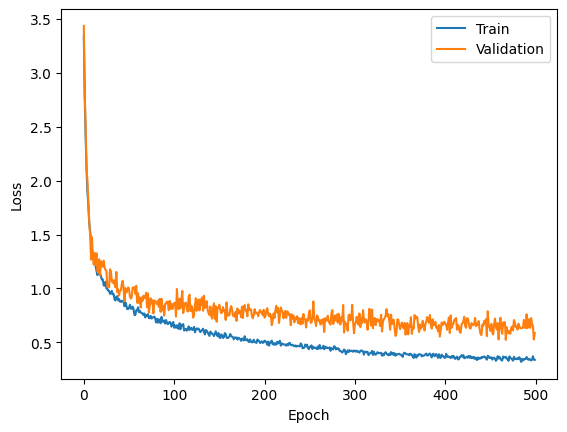

In [48]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list, label='Train')
plt.plot(val_loss_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 직접 만든 GAT layer로 학습
# class GAT(torch.nn.Module):
#     def __init__(self):
#         super(GAT, self).__init__()
#         self.hid = 8
#         self.in_head = 8
#         self.out_head = 1

#         self.conv1 = GATLayer(in_features=dataset.num_features, out_features = self.hid, dropout=0.6, alpha = 0.2)
#         self.conv2 = GATLayer(in_features=self.hid*self.in_head, out_features = dataset.num_classes, dropout=0.6, alpha = 0.2)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index

#         x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv1(x, edge_index)
#         x = F.elu(x)
#         x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv2(x, edge_index)

#         return F.log_softmax(x, dim=1)


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = GAT().to(device)
# data = dataset[0].to(device)


# optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# model.train()
# for epoch in range(1000):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

#     if epoch%200 == 0:
#         print(loss)

#     loss.backward()
#     optimizer.step()

